<a href="https://colab.research.google.com/github/thesalmonification/DSCI400_Revamp/blob/master/JoshWaveletsCNNBasedOnDuncanModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pywt
import tensorflow as tf

In [0]:
#Written in Google Colab: add drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Load the pos/emo sessions
PosEmoSessions = list(pd.read_csv('/content/drive/Shared drives/DSCI400_Revamp/PosEmoSessions.csv',header=None)[0])[:200]
NegEmoSessions = list(pd.read_csv('/content/drive/Shared drives/DSCI400_Revamp/NegEmoSessions.csv',header=None)[0])

print(len(PosEmoSessions))
print(len(NegEmoSessions))

#Concatenate all pos/neg emo sessions
all_sessions = PosEmoSessions + NegEmoSessions

200
200


In [0]:
def Wavelets(waveform_array):
  coeffs = pywt.wavedec(waveform_array, 'db2', level=6) #db2 was nice
  cA6, cD6, cD5,cD4,cD3,cD2,cD1 = coeffs
  cD5 = np.std(cD5)
  cD4 = np.std(cD4)
  cD3 = np.std(cD3)
  cD2 = np.std(cD2)
  cD1 = np.std(cD1)
 
  return [cD5,cD4,cD3,cD2,cD1]

In [0]:
##############################################################################
chs = ['Fp1','Fp2','AF3','AF4','F7','F3','Fz','F4','F8','FC5','FC1','FC2','FC6','T7','C3','Cz','C4','T8','CP5','CP1','CP2','CP6','P7','P3','Pz','P4','P8','PO3','PO4','O1','Oz','O2']

to_binary_dict = {'0':0,'4':0,'6':0,'11':0,'1':1,'2':1,'3':1,'5':1,'12':1}




data_pd = pd.read_hdf('/content/drive/Shared drives/DSCI400_Revamp/Waveform_Vocoded_Equalized_Downsampled_Data.h5',key=all_sessions[0])
session_wavelets = []

for ch in chs:
  waveform_array = data_pd[ch].to_numpy()
  waveform_array = np.reshape(waveform_array,(1,6080))
  wavelets = Wavelets(waveform_array)

  session_wavelets = session_wavelets + wavelets
  ########################################################

session_wavelets = np.array(session_wavelets)
factors = np.reshape(session_wavelets,(1,-1))



label_data = pd.read_hdf('/content/drive/Shared drives/DSCI400_Revamp/Label_Data.h5',key=all_sessions[0]+'_labels').T
label_list = [to_binary_dict[label_data['feltEmo'].to_numpy()[0]]]
##############################################################################


for session in all_sessions[1:]:
  #print(session)
  data_pd = pd.read_hdf('/content/drive/Shared drives/DSCI400_Revamp/Waveform_Vocoded_Equalized_Downsampled_Data.h5',key=session)
  label_data = pd.read_hdf('/content/drive/Shared drives/DSCI400_Revamp/Label_Data.h5',key=session+'_labels').T
  feltEmo_val = label_data['feltEmo'].to_numpy()[0]
  label_list = label_list + [to_binary_dict[feltEmo_val]]
  session_wavelets = []

  ########################################################
  for ch in chs:
    waveform_array = data_pd[ch].to_numpy()
    waveform_array = np.reshape(waveform_array,(1,6080))
    wavelets = Wavelets(waveform_array)

    session_wavelets = session_wavelets + wavelets
  ########################################################

  session_wavelets = np.array(session_wavelets)
  session_wavelets = np.reshape(session_wavelets,(1,-1))
    
  factors = np.concatenate((factors,session_wavelets),axis = 0)

print(factors.shape)
print(len(label_list))

(400, 160)
400


In [0]:
#Make a Keras Model and see what happens...
def KerasModel(lr):
  """
  Paste the Keras Sequential model code here...
  Ensure that you have a learning rate varible "lr" in the optimizer declaration
  """

  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Dense(640,input_shape=(160,),activation='relu'))

  model.add(tf.keras.layers.Dense(200))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(40))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  #YOUR OPTIMIZER MUST CONTAIN A LEARNING RATE!
  sgd = tf.keras.optimizers.Adam(lr = lr, decay = 1e-5)
  
  
  
  model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])
  #model.summary()

  return model

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(factors, label_list, test_size=0.33)

print(X_train.shape)
print(y_train)

(268, 160)
[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Model for learning rate  1e-06
Model for learning rate  1e-05
Model for learning rate  0.0001
Model for learning rate  0.001
Model for learning rate  0.01


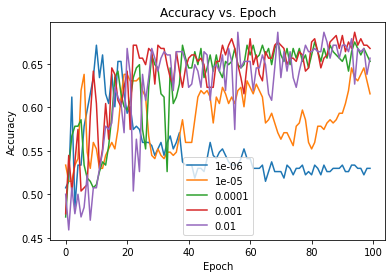

In [0]:
EPOCHS=100
BATCH_SIZE=32


learning_rates = np.power(10*np.ones((5,)),np.array(range(-6,-1))) #10^-6 thru 10^-1


#learning_rates = np.array([.001,.0011,.0012,.0016,.0018])

#learning_rates = np.linspace(.0001,0.01,10)



#Iterate over the learning rates
for lr in learning_rates:
  #Generate model, fit, and plot accuracy over epochs
  model = KerasModel(lr)
  print('Model for learning rate ', lr)
  #model.summary() #To check number of parameters
  history = model.fit(X_train,np.array(y_train),epochs=EPOCHS,batch_size=BATCH_SIZE, verbose=0)
  plt.plot(history.history['accuracy'])
  
  #Destroy the old model to prevent overloading GPU
  tf.keras.backend.clear_session()

#Plot the graph
plt.legend(learning_rates)
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [0]:
#Perform n-fold cross validation
from sklearn.model_selection import KFold


label_array = np.array(label_list)

n_split=10
 
for train_index,test_index in KFold(n_split,shuffle=True).split(factors):
  x_train,x_test=factors[train_index],factors[test_index]
  y_train,y_test=label_array[train_index],label_array[test_index]


  model = KerasModel(0.001)


  history = model.fit(x_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE, verbose=0)
  test_loss, test_acc = model.evaluate(x_test,y_test)

  #plt.figure()
  #plt.stem(model.predict_classes(x_test))
  
  #Destroy the old model to prevent overloading GPU
  tf.keras.backend.clear_session()
  
  
  print("The Number of 1's is:" + str(np.count_nonzero(model.predict_classes(X_test))))
  print("The Number of 0's is:" + str(np.count_nonzero(model.predict_classes(X_test) ==0 )))
  print('-------------------------------------------')

2/2 [==============================] - 0s 4ms/step - loss: 0.6608 - accuracy: 0.5500
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
The Number of 1's is:75
The Number of 0's is:57
-------------------------------------------
2/2 [==============================] - 0s 3ms/step - loss: 0.5983 - accuracy: 0.6250
The Number of 1's is:75
The Number of 0's is:57
-------------------------------------------
2/2 [==============================] - 0s 3ms/step - loss: 0.6085 - accuracy: 0.6250
The Number of 1's is:80
The Number of 0's is:52
-------------------------------------------
2/2 [==============================] - 0s 3ms/step - loss: 0.6471 - accuracy: 0.7250
The Number of 1's is:77
The Number of 0's is:55
--